## Timothé JANNETTA - Louis de MAISTRE

### Structure of the notebook

- [1. Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)
    >[1.1 Basic feature engineering](#1.1-Basic-feature-engineering) <br>
    [1.2 Data Vizualization](#1.2-Data-Vizualization) <br>
    [1.3 Distribution Analysis](#1.3-Distribution-Analysis)
- [2. Forecasting the demand with machine learning algorithms](#2.-Forecasting-the-demand-with-machine-learning-algorithms)
    > [2.1 Data preprocessing](#2.1-Data-preprocessing) <br>
    [2.2 Training several models on the data](#2.2-Training-several-models-on-the-data) <br>
    [2.3 Random Forest Regressor tuning](#2.3-Random-Forest-Regressor-tuning) <br>
    [2.4 Gradient Boosting Regressor Tuning](#2.4-Gradient-Boosting-Regressor-Tuning) <br>
    [2.5 Testing the model on the competition test data set and exporting submission files](#2.5-Testing-the-model-on-the-competition-test-data-set-and-exporting-submission-files)
    
- [3. Conclusion and remarks](#3.-Conclusion-and-remarks)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_data = pd.read_csv('train.csv')

# __1. Exploratory Data Analysis__

***

 __Goal of the project__

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this Kaggle competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C. 

In this section, we describe and vizualise the dataset we're working with, and do some feature engineering, ie transform existing features and/or create new ones so as to improve the quality of the model we'll train on the data.

[Go back to summary](#Structure-of-the-notebook)

In [3]:
df_data.shape

(10886, 12)

The training dataset contains 10886 points associated to 12 features. Let's take a look at what these features look like and what they represent.

In [4]:
df_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


__Description of the features :__

• `datetime` : hourly date + timestamp

• `season` : 1 = spring, 2 = summer, 3 = fall, 4 = winter

• `holiday` : whether the day is considered a holiday

• `workingday` : whether the day is neither a weekend nor holiday

• `weather` :

    1 : Clear, Few clouds, Partly cloudy, Partly cloudy
    2 : Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3 : Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4 : Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    
• `temp` : temperature in Celsius

• `atemp` : "feels like" temperature in Celsius

• `humidity` : relative humidity

• `windspeed` : wind speed

• `casual` : number of non-registered user rentals initiated

• `registered` : number of registered user rentals initiated

• `count` : number of total rentals (count = casual + registered)

[Go back to summary](#Structure-of-the-notebook)

## 1.1 Basic feature engineering

### Removal of outliers

We start by removing the outliers from the column `count` which the target variable we're trying to predict.

Let's plot the histogram and a boxplot of this column in order to visualise the distribution of this variable.

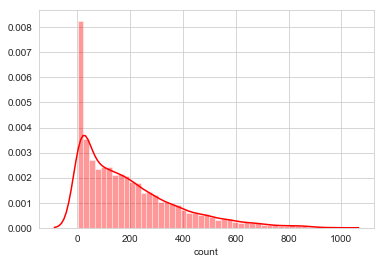

In [6]:
sns.distplot(df_data['count'],color='red');

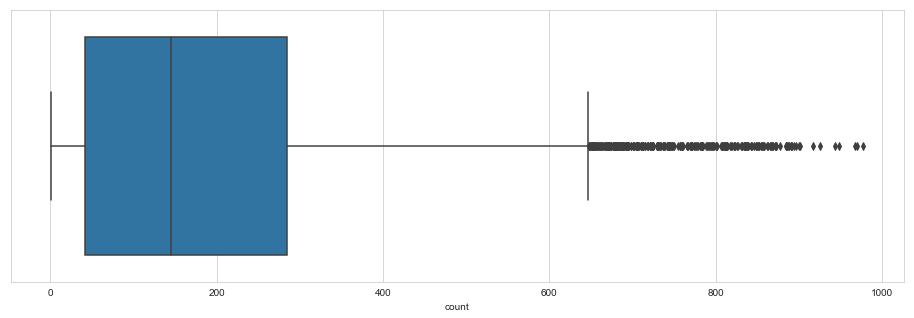

In [7]:
plt.figure(figsize=(16,5));
sns.boxplot(df_data['count']);

In [8]:
df_data['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

We remove the points identified as outliers by the boxplot, ie the points which fall outside the interval $[Q_1-1.5\times IQR,Q_3+1.5\times IQR]$, where $Q_1$ and $Q_3$ are the first and third quartiles of the distribution and $IQR=Q_3-Q_1$ is the interquartile range.

In [9]:
Q1 = 42
Q3 = 284
IQR = Q3 -Q1
df_data = df_data.loc[(df_data['count']<=Q3+1.5*IQR)&(df_data['count']>=Q1-1.5*IQR)]

In [10]:
print('The new shape of our dataset is : ',df_data.shape)

The new shape of our dataset is :  (10586, 12)


[Go back to summary](#Structure-of-the-notebook)

### Dealing with dates and seasons

We create new columns `year`, `hour`, `day`, `month`, `weekend`, transform the values of the 'season' from integers to their associated names, and finally drop the 'datetime' column to make it the index of our dataframe.

In [11]:
df_data['datetime']=pd.to_datetime(df_data["datetime"])
df_data['year']=df_data['datetime'].apply(lambda d : d.year)
df_data['hour']=df_data['datetime'].apply(lambda d : d.hour)
df_data['day']=df_data['datetime'].apply(lambda d : d.day) # day number in the week
df_data['day_name']=df_data['datetime'].apply(lambda d : d.day_name()) # name of the day
df_data['month']=df_data['datetime'].apply(lambda d : d.month) # month number 
df_data['month_name']=df_data['datetime'].apply(lambda d : d.month_name()) # name of the month

In [12]:
dico_seasons = {1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'}
df_data['season']=df_data['season'].apply(lambda s : dico_seasons[s])

In [13]:
df_data.set_index('datetime', inplace=True)

In [14]:
df_data['weekend']=df_data['day_name'].isin(['Saturday','Sunday'])*1

We display a random sample of our new dataframe to see what it looks like.

In [15]:
df_data.sample(n=7)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,hour,day,day_name,month,month_name,weekend
datetime,,,,,,,,,,,,,,,,,,
2012-09-08 10:00:00,Summer,0,0,1,30.34,34.850,70,26.0027,100,322,422,2012,10,8,Saturday,9,September,1
2012-12-02 10:00:00,Fall,0,0,2,12.30,16.665,87,0.0000,63,230,293,2012,10,2,Sunday,12,December,1
2012-04-09 12:00:00,Spring,0,1,1,22.14,25.760,28,47.9988,94,186,280,2012,12,9,Monday,4,April,0
2011-08-10 15:00:00,Summer,0,1,1,35.26,37.120,30,22.0028,53,141,194,2011,15,10,Wednesday,8,August,0
2012-10-15 23:00:00,Fall,0,1,1,18.86,22.725,63,15.0013,9,72,81,2012,23,15,Monday,10,October,0
2012-07-03 06:00:00,Summer,0,1,1,28.70,32.575,65,8.9981,5,149,154,2012,6,3,Tuesday,7,July,0
2011-08-05 00:00:00,Summer,0,1,1,27.06,31.060,74,7.0015,13,41,54,2011,0,5,Friday,8,August,0


[Go back to summary](#Structure-of-the-notebook)

## 1.2 Data Vizualization

#### Average count by hour over the whole data set

We first plot the average value of 'count' by hour to see how demand evolves throughout the day. We see that it is higher between 8am and 5pm, with peaks at these hours, and then quite uniformly decreasing after 5pm. This pattern is naturally explained by business hours : people rent more bikes around 8am and 5pm to go to work and come back home (less and less after 5pm).

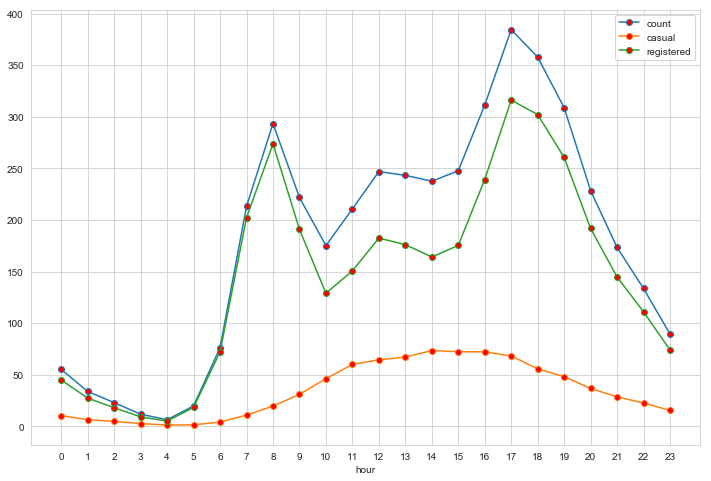

In [16]:
df_data[['hour','count','casual','registered']].groupby(by=['hour']).mean().\
plot(marker = 'o',markerfacecolor='red',figsize=(12,8),xticks=np.arange(0,24));

#### Holidays

If we compare the evolution of average demand, by distinguishing between regular days and holidays, we notice that during regular days (`holiday` = 0) the pattern is fairly similar to the overall evolution observed previously, whereas on holidays, the peaks around 8am and 5pm are less obvious and we rather observe a sort of "sinusoid", centered in the afternoon.

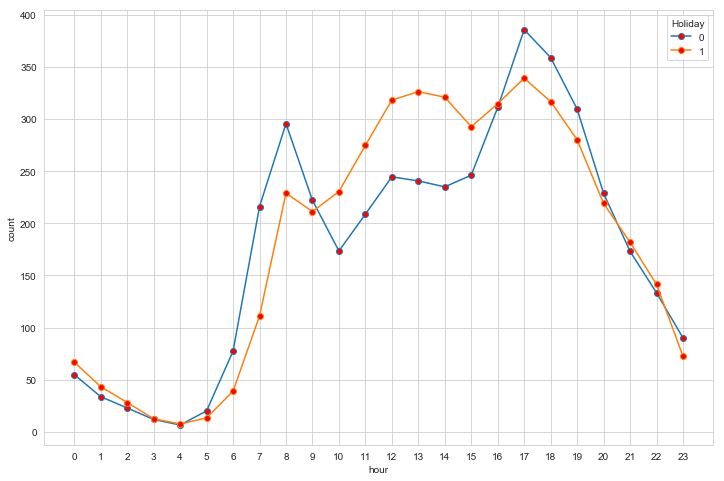

In [17]:
plt.figure(figsize=(12,8))
plt.plot(df_data.loc[df_data['holiday']==0,['hour','count']].groupby(by=['hour']).mean(),\
         marker = 'o',markerfacecolor='red', label=0);
plt.plot(df_data.loc[df_data['holiday']==1,['hour','count']].groupby(by=['hour']).mean(),\
         marker = 'o',markerfacecolor='red', label=1);
plt.xticks(np.arange(0,24))
plt.xlabel('hour')
plt.ylabel('count')
plt.legend(title='Holiday');

On the following bar plot, we observe that, on average, people rent less bikes in winter and that in summer and fall, more bikes are rented during holidays (on average), and the opposite happens in winter and spring.

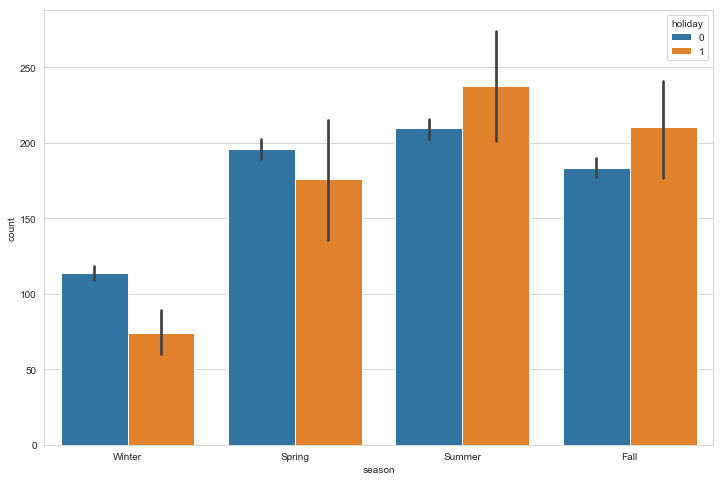

In [18]:
plt.figure(figsize=(12,8));
sns.barplot(x='season',y='count',hue='holiday', data=df_data);

#### Influence of the seasons/months

The following graphs confirm the observation that less bikes are rented during winter; we see that the daily evolution of the demand is quite similar for the other seasons. We also see on the bar plot that the demand is higher in June, July, August and that the overall is quite smooth : increases as we approach and then decreases towards winter.

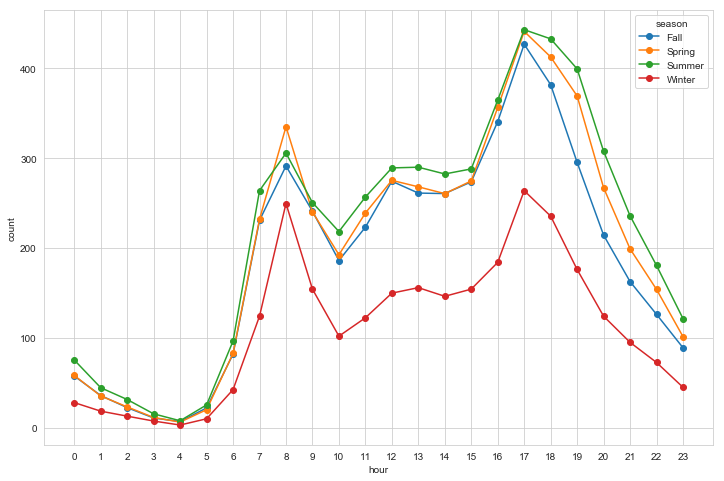

In [19]:
df_data[['hour','season','count']].\
groupby(by=['season','hour']).mean().pivot_table(index='hour',columns='season',values='count').\
plot(marker = 'o', figsize=(12,8),xticks=np.arange(0,24))
plt.ylabel('count');

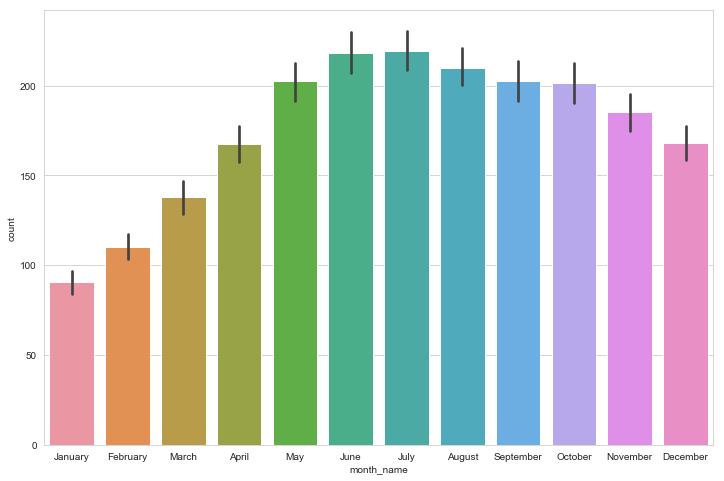

In [20]:
plt.figure(figsize=(12,8))
sns.barplot(x='month_name',y='count',data=df_data);

#### Weekdays VS Weekend

Here we distinguish between weekdays and weekend and roughly observe the same behavior as between holidays and non holidays, even more pronounced. This is logical because there are many days which are not holidays but are not business days either because they fall during the weekend.

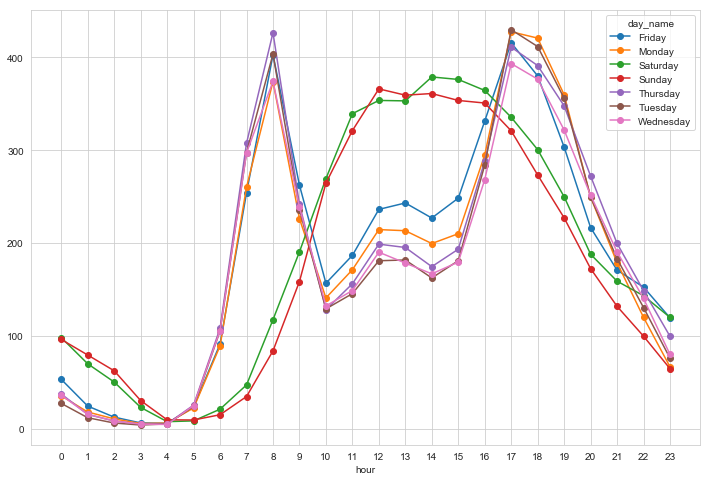

In [21]:
df_data[['hour','day_name','count']].\
groupby(by=['day_name','hour']).mean().pivot_table(index='hour',columns='day_name',values='count').\
plot(marker = 'o', figsize=(12,8),xticks=np.arange(0,24));

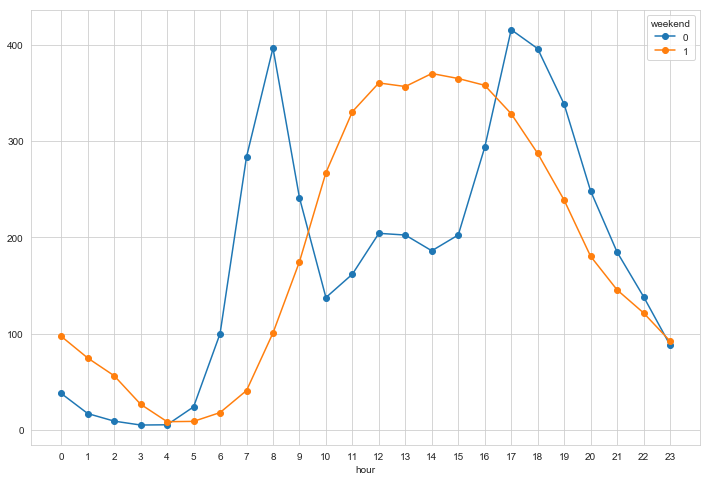

In [22]:
df_data[['hour','weekend','count']].\
groupby(by=['weekend','hour']).mean().pivot_table(index='hour',columns='weekend',values='count').\
plot(marker = 'o', figsize=(12,8),xticks=np.arange(0,24));

#### Influence of the weather

Quite logically, the worse the weather, the fewer people rent bicycles.

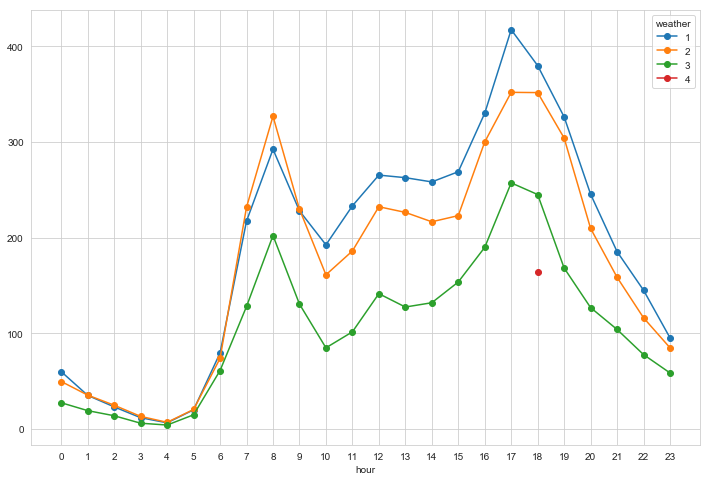

In [23]:
df_data[['hour','weather','count']].\
groupby(by=['weather','hour']).mean().pivot_table(index='hour',columns='weather',values='count').\
plot(marker = 'o', figsize=(12,8),xticks=np.arange(0,24));

[Go back to summary](#Structure-of-the-notebook)

## 1.3 Distribution Analysis

#### Distributions of the continuous variables

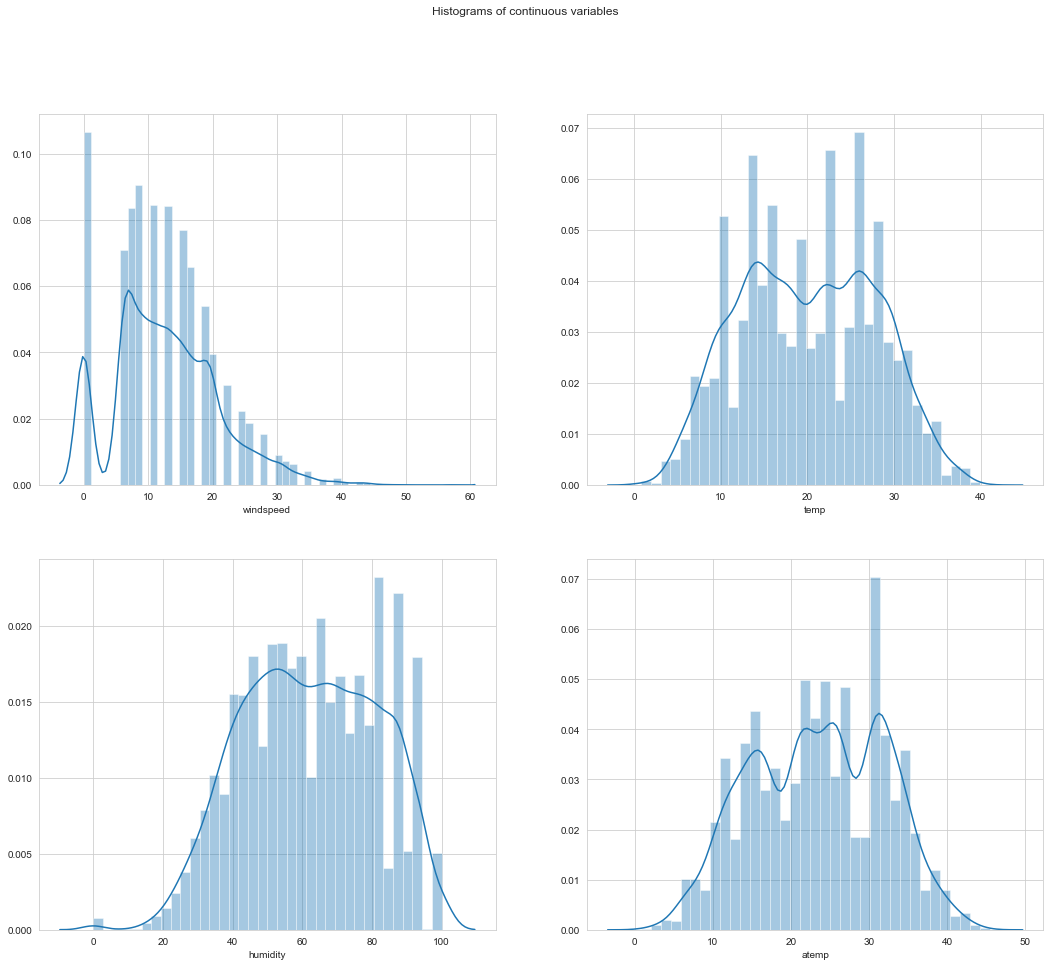

In [24]:
fig, axes = plt.subplots(2,2, figsize=(18,15))
sns.distplot(df_data['windspeed'], ax=axes[0,0])
sns.distplot(df_data['temp'], ax=axes[0,1])
sns.distplot(df_data['atemp'], ax=axes[1,1])
sns.distplot(df_data['humidity'], ax=axes[1,0])
plt.suptitle('Histograms of continuous variables');

#### Correlation analysis

Now after seeing the distribution of various discrete as well as continuous variables we can see the correlation between them using a heat map.

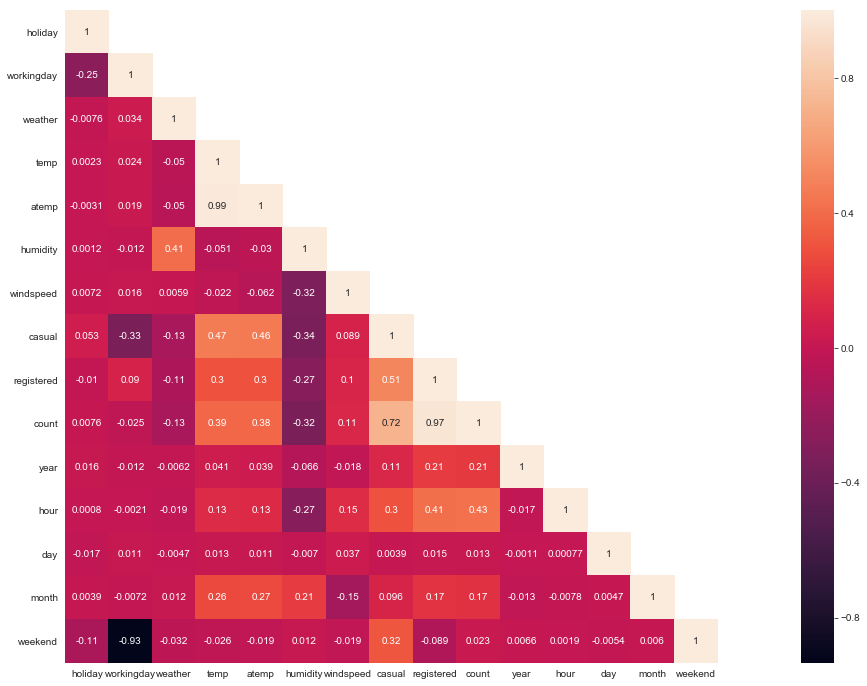

In [25]:
cor_mat= df_data[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True);

Inferences from the above heatmap :

- `temp` and `atemp` are very highly positively correlated (0.99), as expected. When building our model, one of the variables has to be dropped since they will exhibit colinearity and roughly explain the same amount of variance in our data.

- `temp` and `humidity` are respectively positively and negatively correlated with the 'count' variable : humidity is inversely related to count as expected as the weather is humid people won't be likely to use bikes, and the reverse goes for the temperature.

- Similarly, `weather` and 'count' are inversely related. This is because as `weather` increases (from 1 to 4), it means that weather is getting worse and so less people will rent bikes.

- `casual` and `working day` are highly inversely related as you would expect : people who rent bikes on working day are more likely to be registered users.

- `weekend` and `workingday` are highly inverely related, as expected : we have `workingday` ≈ 1 - 'weekend'. We will only keep 'workingday' to train our model.

- Overall, the features that most affect the target variable `count` are `temp`, `atemp`, `humidity` and `hour`.


[Go back to summary](#Structure-of-the-notebook)

# __2. Forecasting the demand with machine learning algorithms__

***

Now that we've finished the EDA part, we can begin building our prediction model.

## 2.1 Data preprocessing

We start by dropping unnecessary columns : 

- `temp` and `weekend` for reasons explained above.
- `casual` and `registered` because they are leakage variables that we can't use to build a model, since they won't be available in our test data.
- `year`, `day` and `month` because we feel that they might cause our model to overfit (see the remarks at the end of the notebook on this matter), or because we feel they are redondant : the more significant monthly effects will already be captured by the 'season' variable and the daily effects seem to be contained in `workingday`.

In [26]:
columns_to_drop = ['temp','weekend','casual','registered','month_name','day_name','year','day','month']

In [27]:
df_data_forecast = df_data.drop(columns_to_drop, axis=1)

In [28]:
df_data_forecast.sample(5)

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,hour
datetime,,,,,,,,,
2012-01-18 15:00:00,Winter,0,1,1,12.880,33,35.0008,130,15
2011-12-02 03:00:00,Fall,0,1,1,13.635,80,0.0000,1,3
2011-01-09 08:00:00,Winter,0,0,1,4.545,49,19.0012,10,8
2011-02-07 17:00:00,Winter,0,1,2,15.910,70,11.0014,216,17
2011-01-16 23:00:00,Winter,0,0,2,11.365,40,7.0015,18,23


Here we turn the `weather` and `season` features into categorical variables in order to make dummy variables.

In [29]:
df_data_forecast[['weather','season']]=df_data[['weather','season']].astype('category')

In [30]:
df_data_forecast=pd.get_dummies(df_data_forecast)

In [31]:
df_data_forecast.columns

Index(['holiday', 'workingday', 'atemp', 'humidity', 'windspeed', 'count',
       'hour', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'weather_1', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

In [32]:
df_data_forecast.sample(5)

,holiday,workingday,atemp,humidity,windspeed,count,hour,season_Fall,season_Spring,season_Summer,season_Winter,weather_1,weather_2,weather_3,weather_4
datetime,,,,,,,,,,,,,,,
2012-10-16 20:00:00,0,1,22.725,55,0.0000,432,20,1,0,0,0,1,0,0,0
2012-04-10 07:00:00,0,1,17.425,71,7.0015,384,7,0,1,0,0,1,0,0,0
2012-12-13 16:00:00,0,1,17.425,39,7.0015,406,16,1,0,0,0,1,0,0,0
2011-03-01 11:00:00,0,1,13.635,45,16.9979,56,11,0,0,0,1,1,0,0,0
2011-12-16 00:00:00,0,1,24.240,72,22.0028,72,0,1,0,0,0,1,0,0,0


Finally this is what our dataset looks like, and we're now ready to start building models on it. 

[Go back to summary](#Structure-of-the-notebook)

### Train/Test split

In [33]:
from sklearn.model_selection import train_test_split, cross_val_score

We split our data into two sets : a training set (80% of the data) and a validation set.

In [34]:
X = df_data_forecast.drop('count', axis=1)
y = df_data_forecast['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Root Mean Squared Logarithmic Error (RMSLE)

In [35]:
from sklearn.metrics import mean_squared_log_error as msle

The RMSLE scorer used for the evaluation of the prediction in this Kaggle competition, is defined as such : 

$$RMSLE = \sqrt{\frac{1}{n}\sum\limits_{i=1}^n (\log (1+\hat{y}_i)-\log (1+y_i))^2}$$

where $n$ is the number of points in the dataset and $\hat{y}_i$ and $y_i$ are respectively the predicted and actual counts (ie the number of bikes rented in the day).

In [36]:
def RMSLE(y,y_hat):
    return np.sqrt(msle(y,y_hat))

[Go back to summary](#Structure-of-the-notebook)

## 2.2 Training several models on the data

We first try to fit naively different models, without trying to optimize their input parameters (we just let scikit-learn default parameters), to see which one seems best adapted to our problem.

In [37]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

Since the score we're trying to minimize is actually the least squares distance between $\log (1+\hat{y})$ and $\log (1+y)$ (where $\hat{y}$ and $y$ represent the predicted and actual values of our target variable `count`), we decide to directly regress $\log (1+y)$ on our features, to obtain $\log (1+\hat{y})$, and then we retrieve the `count` prediction by applying the inverse transformation $x \mapsto e^x-1$. We mainly adopt this convention for the sake of simplicity, because regressors implemented in `scikit-learn` already come with a least squares scorer, which is most of the time their default scorer.

In [38]:
models = [LinearRegression(), KNeighborsRegressor(), MLPRegressor(), 
          RandomForestRegressor(), GradientBoostingRegressor(), AdaBoostRegressor(), XGBRegressor()]

model_names = ['Linear Regression', 'KNN', 'Neural Network', 'Random Forest', 'Gradient Boosting', 'AdaBoost', 'XGBoost']
RMSLE_scores = []

for model in models:
    
    model.fit(X_train, np.log1p(y_train))
    y_hat = np.exp(model.predict(X_test))-1
    
    RMSLE_scores.append(RMSLE(y_test, y_hat))

In [39]:
pd.DataFrame({'Model': model_names, 'RMSLE': RMSLE_scores}).sort_values(by= 'RMSLE').set_index('Model')

,RMSLE
Model,
Random Forest,0.419088
Gradient Boosting,0.439392
XGBoost,0.443246
Neural Network,0.556965
AdaBoost,0.667068
KNN,0.734712
Linear Regression,1.003913


The models that yield the best scores on the validation set are __Random Forest__ and __Gradient Tree Boosting__. We consequently choose to improve our prediction with these models, even though this choice is quite arbitrary : because they behave better than other models with default parameters doesn't mean these other predictors can't get much better with a bit of tuning. Nevertheless we need to pick one or two algorithms to focus on, and these will be random forest and gradient boosting.

### A word on ensemble methods

Random Forest and Gradient Boosting models are part of a type of methods called __ensemble methods__.

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Two families of ensemble methods are usually distinguished:

- In __averaging methods__, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced. _<u>Examples</u> : Bagging, Random Forest_

- By contrast, in __boosting methods__, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble. _<u>Examples</u> : AdaBoost, Gradient Tree Boosting_

[Go back to summary](#Structure-of-the-notebook)

## 2.3 Random Forest Regressor tuning

### A word on random forests

In ensemble algorithms, bagging methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction. These methods are used as a way to reduce the variance of a base estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. In many cases, bagging methods constitute a very simple way to improve with respect to a single model, without making it necessary to adapt the underlying base algorithm.

In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.

__Parameters__

A random forest model depends upon many hyperparameters that need tuning in order to build the model that best fit our data. In order to achieve this optimization and try to learn the best parameters of our prediction function, we are gonna use k-fold cross-validation. 

In [40]:
from sklearn.model_selection import GridSearchCV

Here we are first gonna run a grid search to optimize parameters other than `n_estimators`, and later optimize `n_estimators` alone, with the other parameters newly found, because of computing time considerations. Indeed, when we begin adding a lot of trees in the forest, the calculations become a bit long and we face a prohibitive time of computation if we combine it with the grid search.

In [41]:
# Number of trees in the forest
n_estimators = [10]
# Number of features considered at every split
max_features = ['auto','sqrt']
# Maximum depth of the trees
max_depth = [None, 5, 10]
# Minimum number of samples required to split a node
min_samples_split = [2, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10]

# Create the grid

rf_grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
       "min_samples_split" : min_samples_split,
       "min_samples_leaf" : min_samples_leaf}

In [42]:
CV_rf_reg = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid= rf_grid, 
                         cv=5, verbose=1, scoring='neg_mean_squared_error', n_jobs=-1)

In [43]:
CV_rf_reg.fit(X, np.log1p(y))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 473 out of 480 | elapsed:   26.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   27.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10], 'max_features': ['auto', 'sqrt'], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 10, 15, 20], 'min_samples_leaf': [1, 2, 4, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [44]:
y_hat = np.exp(CV_rf_reg.predict(X))-1
print("RMSLE on the training set with Random Forest Regression optimized by grid search: ", RMSLE(y,y_hat))

RMSLE on the training set with Random Forest Regression optimized by grid search:  0.3158930598269883


Let's display the optimal parameters found during the grid search.

In [45]:
CV_rf_reg.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 10}

Now we fix these parameters and try to change to number of trees in the forest to find the best value of `n_estimators`.

In [46]:
rf_reg = CV_rf_reg.best_estimator_
RMSLE_score_rf = []
n_estimators = [5,10,50,100,200,300,500,1000,2000, 5000]
for n in n_estimators:
    rf_reg.n_estimators = n
    rf_reg.fit(X_train, np.log1p(y_train))
    y_hat = np.exp(rf_reg.predict(X_test))-1
    RMSLE_score_rf.append(RMSLE(y_test,y_hat))

In [47]:
df_scores_rf = pd.DataFrame({"n_trees": n_estimators, "Validation RMSLE": RMSLE_score_rf}).set_index('n_trees')
df_scores_rf['performance_gain'] = -df_scores_rf['Validation RMSLE'].pct_change()

In [48]:
df_scores_rf

,Validation RMSLE,performance_gain
n_trees,,
5,0.429151,NaN
10,0.415095,0.032753
50,0.406159,0.021529
100,0.405497,0.001630
200,0.405711,-0.000528
300,0.405238,0.001165
500,0.405393,-0.000382
1000,0.404786,0.001496
2000,0.404769,0.000042


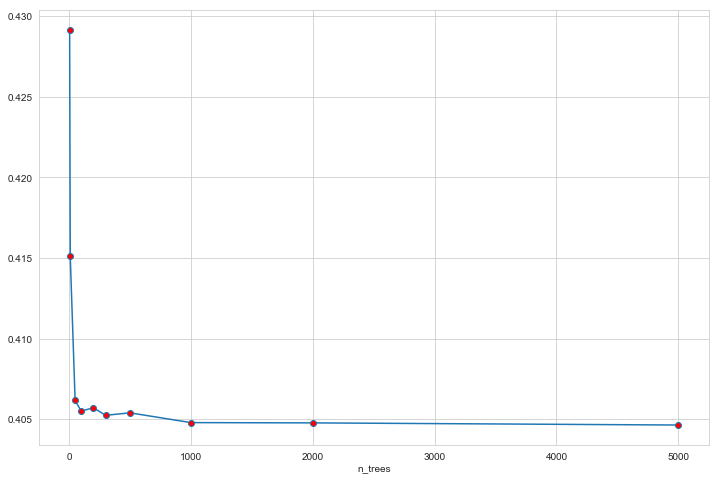

In [49]:
df_scores_rf['Validation RMSLE'].plot(marker = 'o', markerfacecolor='red', figsize=(12,8));

We see that the RMSLE score on the validation test is lowest for `n_estimators` = 1000.

In [50]:
rf_reg = CV_rf_reg.best_estimator_
rf_reg.n_estimators = 1000 # we set n_estimators to its optimal value
rf_reg.fit(X_train, np.log1p(y_train))
y_hat = np.exp(rf_reg.predict(X_test))-1

print("RMSLE on validation set with Random Forest Regression optimized by cross-validaton : ", RMSLE(y_test,y_hat))

RMSLE on validation set with Random Forest Regression optimized by cross-validaton :  0.40478637187984956


The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples. The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features. In scikit-learn, the fraction of samples a feature contributes to is combined with the decrease in impurity from splitting them to create a normalized estimate of the predictive power of that feature.

Below we plot the relative importance of the different features in our fitted model.

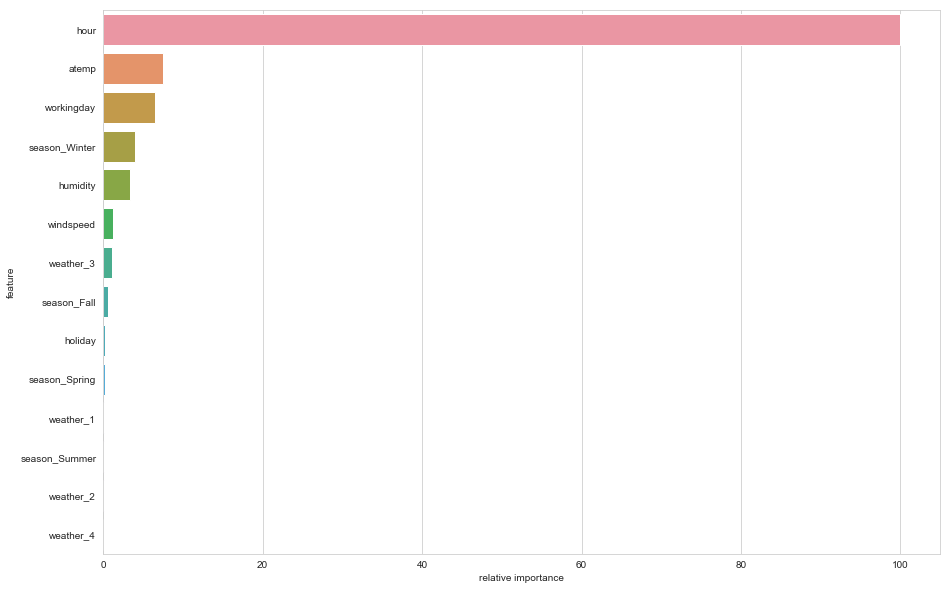

In [51]:
feature_importance = rf_reg.feature_importances_
plt.figure(figsize=(15,10))
sns.barplot(y='feature',x='relative importance',
            data=pd.DataFrame({'feature': X.columns, 'relative importance': 100.0*feature_importance/feature_importance.max()}).sort_values(by='relative importance',ascending=False),
            orient="h");

We observe that the most important features roughly correspond to the features that were most correlated with the target variable `count`, and that the stronger predictor is quite naturally the column `hour`.

[Go back to summary](#Structure-of-the-notebook)

## 2.4 Gradient Boosting Regressor Tuning

### A word on gradient tree boosting

Gradient Tree Boosting or Gradient Boosted Regression Trees (GBRT) is a generalization of boosting to arbitrary differentiable loss functions (in our case least squares). GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems.

The core principle of boosting is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. 

__Mathematical formulation__

GBRT considers additive models of the following form:

$$F(x) = \sum_{m=1}^{M} \gamma_m h_m(x)$$

where  are the basis functions which are usually called weak learners in the context of boosting. Gradient Tree Boosting uses decision trees of fixed size as weak learners. Decision trees have a number of abilities that make them valuable for boosting, namely the ability to handle data of mixed type and the ability to model complex functions.

Similar to other boosting algorithms, GBRT builds the additive model in a greedy fashion:

$$F_m(x) = F_{m-1}(x) + \gamma_m h_m(x)$$

where the newly added tree $h_m$ tries to minimize the loss $L$, given the previous ensemble $F_{m-1}$ :

$$h_m =  \arg\min_{h} \sum_{i=1}^{n} L(y_i,
F_{m-1}(x_i) + h(x_i))$$

The initial model $F_0$ is problem specific, for least-squares regression one usually chooses the mean of the target values.

Gradient Boosting attempts to solve this minimization problem numerically via steepest descent: The steepest descent direction is the negative gradient of the loss function evaluated at the current model  which can be calculated for any differentiable loss function:

$$F_m(x) = F_{m-1}(x) - \gamma_m \sum_{i=1}^{n} \nabla_F L(y_i,
F_{m-1}(x_i))$$

Where the step length $\gamma_m $ is chosen using line search:

$$\gamma_m = \arg\min_{\gamma} \sum_{i=1}^{n} L(y_i, F_{m-1}(x_i)
- \gamma \frac{\partial L(y_i, F_{m-1}(x_i))}{\partial F_{m-1}(x_i)})$$

The algorithms for regression and classification only differ in the concrete loss function used.

__Regularization : shrinkage__

A simple regularization strategy that scales the contribution of each weak learner by a factor $\nu$ can be written as :

$$F_m(x) = F_{m-1}(x) + \nu \gamma_m h_m(x)$$

The parameter $\nu$ is also called the _learning rate_ because it scales the step length the gradient descent procedure; it can be set via the `learning_rate` parameter.

Now that we have presented the idea behing gradient tree boosting regression, we can get into tuning our boostin regression model. The process here is quite similar to the tuning of our random forest regressor so we won't be commenting all the steps again.

In [52]:
gbrt_grid = {'learning_rate' : [0.1, 0.05, 0.02, 0.01], # shrinks the contribution of each tree by learning_rate
            'max_depth': [4, 6, 8],
            'min_samples_leaf': [1, 2, 5, 10],
            'max_features': ['auto', 'sqrt'] }

In [53]:
CV_gbrt_reg = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid= gbrt_grid, 
                         cv=5, verbose=1, scoring='neg_mean_squared_error', n_jobs=-1)

In [54]:
CV_gbrt_reg.fit(X, np.log1p(y))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  4.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [4, 6, 8], 'min_samples_leaf': [1, 2, 5, 10], 'max_features': ['auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [55]:
print("RMSLE on the training set with Random Forest Regression optimized by grid search: ", np.sqrt(-CV_gbrt_reg.score(X,np.log1p(y))))

RMSLE on the training set with Random Forest Regression optimized by grid search:  0.33374892429200514


In [56]:
CV_gbrt_reg.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 10}

In [57]:
CV_gbrt_reg.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [58]:
gbrt_reg = CV_gbrt_reg.best_estimator_
RMSLE_score_gbrt = []
n_estimators = [10,100,200,500,1000,2000,5000] # number of weak learners to fit
for n in n_estimators:
    gbrt_reg.n_estimators = n
    gbrt_reg.fit(X_train, np.log1p(y_train))
    y_hat = np.exp(gbrt_reg.predict(X_test))-1
    RMSLE_score_gbrt.append(RMSLE(y_test,y_hat))

In [60]:
df_scores_gbrt = pd.DataFrame({"n_trees": n_estimators, "Validation RMSLE": RMSLE_score_gbrt}).set_index('n_trees')
df_scores_gbrt['performance_gain'] = -df_scores_gbrt['Validation RMSLE'].pct_change()
df_scores_gbrt

,Validation RMSLE,performance_gain
n_trees,,
10,0.683258,NaN
100,0.385476,0.435827
200,0.379730,0.014906
500,0.383822,-0.010775
1000,0.391760,-0.020682
2000,0.404986,-0.033761
5000,0.426916,-0.054150


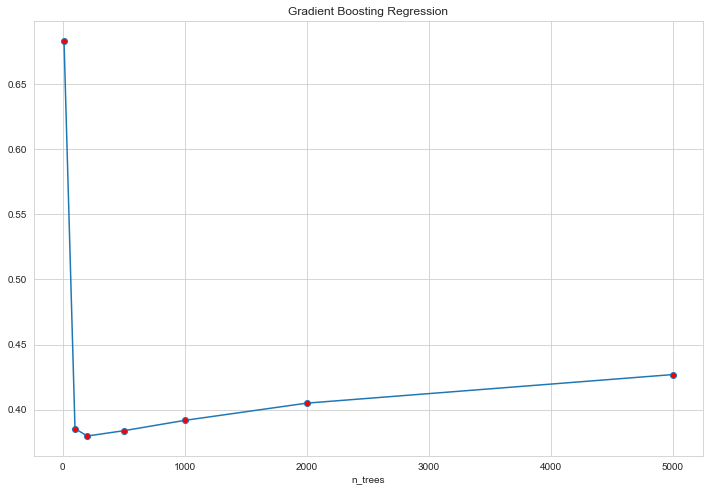

In [61]:
df_scores_gbrt['Validation RMSLE'].plot(marker = 'o', markerfacecolor='red', figsize=(12,8), title = 'Gradient Boosting Regression');

Here we observe that if we use too much weak learners (more than 200), the RMSLE score does not improve and even starts to increase. This is typical of a case of overfitting.

In [62]:
gbrt_reg = CV_gbrt_reg.best_estimator_
gbrt_reg.n_estimators = 200
gbrt_reg.fit(X_train, np.log1p(y_train))
y_hat = np.exp(gbrt_reg.predict(X_test))-1

print("RMSLE on validation set with Gradient Boosting Regression optimized by cross-validaton : ", RMSLE(y_test,y_hat))

RMSLE on validation set with Gradient Boosting Regression optimized by cross-validaton :  0.3797300101480136


[Go back to summary](#Structure-of-the-notebook)

### 2.5 Testing the model on the competition test data set and exporting submission files

Finally we can fit our tuned models to the whole dataset and use them to obtain our predictions on the competition testing dataset, for which we don't have the actual values of `count`. 

Then we can submit our results to the Kaggle competition late submission page (https://www.kaggle.com/c/bike-sharing-demand/submit) to discover the quality of our predictions via the RMSLE score.

In [63]:
import data_preprocessing # auxiliary python file with a function that transform the raw dataset into a dataset ready to be fitted to our models

In [64]:
df_test = data_preprocessing.process(pd.read_csv('test.csv'))

In [65]:
rf_reg.n_estimators = 1000
rf_reg.fit(X, np.log1p(y))
y_hat = np.exp(rf_reg.predict(df_test))-1
submission = pd.DataFrame(data={'datetime':df_test.index, 'count': y_hat})
submission.to_csv('random_forest_submission.csv', index= False)

The random forest model yields a RMSLE score of : 0.44729

In [66]:
gbrt_reg.n_estimators = 200
gbrt_reg.fit(X, np.log1p(y))
y_hat = np.exp(gbrt_reg.predict(df_test))-1
submission = pd.DataFrame(data={'datetime':df_test.index, 'count': y_hat})
submission.to_csv('gbrt_submission.csv', index= False)

The gradient boosting model yields a RMSLE score of : 0.44665

# 3. Conclusion and remarks

- In the end, our gradient boosting predictor is slightly better than the random forest regressor.

- At one point, we had tried to embed the created feature `year` in our models, which gave us surprisingly outstanding results : it yielded a RMSLE score around 0.3 on our validation set when the model was trained on the training set. However, when tested on the Kaggle competition test dataset, the model behaved poorly whith a score around 1.5. We can see that as a case of overfitting : we don't actually know what the testing dataset corresponds to (which city etc.) but we believe that there was some critical phenomenon contained in our data that was well explained by the year (2011 or 2012) and that this phenomenon was absent of the testing dataset (the years were the same : 2011 and 2012) . In any case, this is somehow reassuring that the model behaved poorly on the competition testing set because it seemed quit odd that year could be such a strong predictor, and that just adding it as a feature was responsible for such a drastic improve of our RMSLE score (even more so on the dataset which contained only two years of data).

- Finally, one point that could have been improved, other than testing other algorithms or performing a better optimization, is the quality of our data cleaning and feature engineering, especially about the feature `windspeed`. Indeed this column contained a lot of abnormal 0's, as can be seen in the histogram of this variable. We thought that it was actually quite hard to determine whether these 0's were legit values our outliers, so we decided to leave it as it was. However, one good approach could have been maybe to try and fill these 0's by regression them on the other features of the dataset : we could have fitted a predictive model on the part our data for which `windspeed`≠ 0, and use this fitted model on the remaining data to replace the values of `windspeed` that are 0.

[Go back to summary](#Structure-of-the-notebook)